In [87]:
import pyarrow
import fastparquet
import pandas as pd
import holidays
import matplotlib.pyplot as plt
import seaborn as sns


## Exploratory Analysis - Data Preview 

In [72]:
#Data Download and Preview 
df = pd.read_parquet('/Users/camryncurtis/Documents/GitHub/Capstone-Project/data/raw/prepros_summer_lax_snappy.parquet')
print(df.head())


                              legId  searchDate  flightDate startingAirport  \
0  006987aea766442f625ccd84bde23ff3  2022-04-17  2022-06-01             LAX   
1  2181b0ab7161f081228a0c600d756eaf  2022-04-17  2022-06-01             LAX   
2  1ad5b31e3269695b008e5001f06d627a  2022-04-17  2022-06-01             LAX   
3  8e3f3570d010c80500d98f66bfc49777  2022-04-17  2022-06-01             LAX   
4  7ff208a7f5d75b1a97d54b983eb4fabf  2022-04-17  2022-06-01             LAX   

  destinationAirport fareBasisCode travelDuration  isBasicEconomy  \
0                ATL         GA7NR       PT14H25M           False   
1                ATL         GA7NR       PT10H42M           False   
2                ATL         UA7NR        PT9H49M           False   
3                ATL        U0XSNR       PT12H42M           False   
4                ATL       M03PXP5        PT6H17M           False   

   isRefundable  isNonStop  ...  seatsRemaining  totalTravelDistance  \
0         False      False  ...       

In [65]:
#Datatype and Summary Statistics
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4329731 entries, 0 to 4329730
Data columns (total 22 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   legId                              object 
 1   searchDate                         object 
 2   flightDate                         object 
 3   startingAirport                    object 
 4   destinationAirport                 object 
 5   fareBasisCode                      object 
 6   travelDuration                     object 
 7   isBasicEconomy                     bool   
 8   isRefundable                       bool   
 9   isNonStop                          bool   
 10  baseFare                           float64
 11  totalFare                          float64
 12  seatsRemaining                     int64  
 13  totalTravelDistance                float64
 14  segmentsDepartureTimeEpochSeconds  object 
 15  segmentsArrivalTimeEpochSeconds    object 
 16  segmentsArrivalAir

In [73]:
#Handle Data Types

# Convert boolean columns to 0 and 1
boolean_columns = ['isBasicEconomy', 'isRefundable', 'isNonStop'] 
df[boolean_columns] = df[boolean_columns].astype(int)

#Change dates to datetime
df['searchDate'] = pd.to_datetime(df['searchDate'])
df['flightDate'] = pd.to_datetime(df['flightDate'])

#Still need to convert categorical columns before modeling 
categorical_columns = ['startingAirport', 'destinationAirport', 'fareBasisCode']

In [67]:
# Check for missing values
missing_values = df.isnull().sum()
print(missing_values)


legId                                      0
searchDate                                 0
flightDate                                 0
startingAirport                            0
destinationAirport                         0
fareBasisCode                              0
travelDuration                       4329731
isBasicEconomy                             0
isRefundable                               0
isNonStop                                  0
baseFare                                   0
totalFare                                  0
seatsRemaining                             0
totalTravelDistance                   456372
segmentsDepartureTimeEpochSeconds    3286745
segmentsArrivalTimeEpochSeconds      3286745
segmentsArrivalAirportCode                 0
segmentsDepartureAirportCode               0
segmentsAirlineName                        0
segmentsDurationInSeconds            3286745
segmentsDistance                     3356141
segmentsCabinCode                          0
dtype: int

In [68]:
#Drop totalTravelDistance and segmentsDistance due to missing values
df.drop(columns=['segmentsDistance', 'totalTravelDistance'], inplace=True)


## Exploratory Analysis - Visualizations 

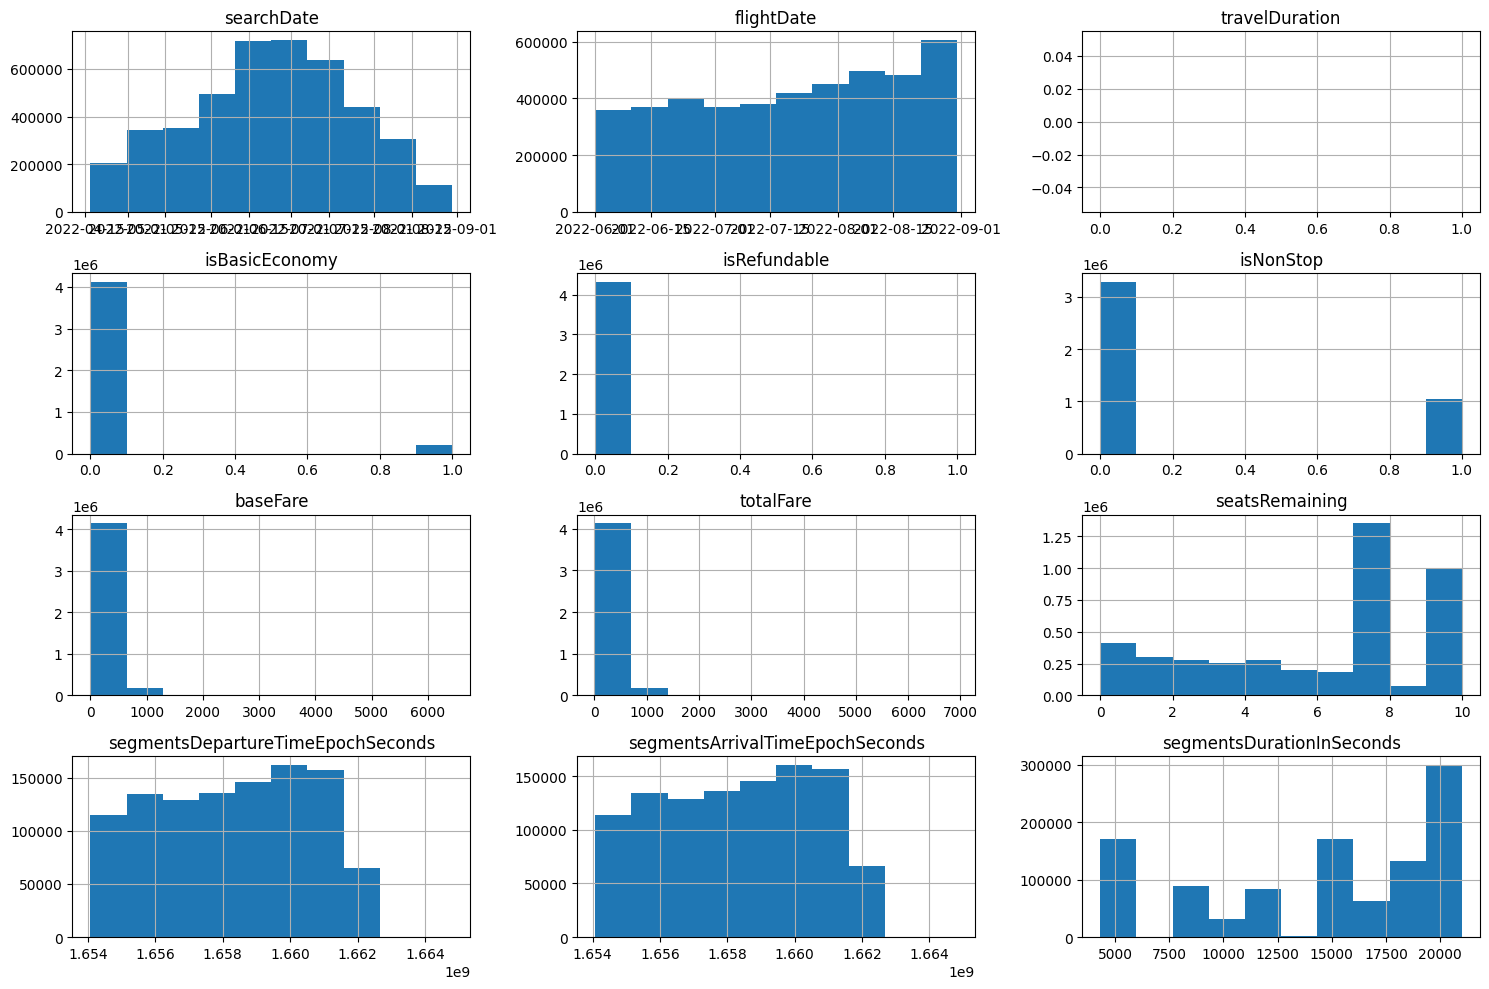

In [ ]:
# Plot histograms for numerical columns
df.hist(figsize=(15, 10))
plt.tight_layout()
plt.show()


## Feature Engineering 

In [88]:
#Time Related Features
df['days_to_departure'] = (df['flightDate'] - df['searchDate']).dt.days

df['flight_month'] = df['flightDate'].dt.month
df['flight_day_of_week'] = df['flightDate'].dt.dayofweek
df['flight_hour'] = df['flightDate'].dt.hour

df['search_month'] = df['searchDate'].dt.month
df['search_day_of_week'] = df['searchDate'].dt.dayofweek
df['search_hour'] = df['searchDate'].dt.hour

us_holidays = holidays.US()
df['is_holiday'] = df['flightDate'].apply(lambda date: 1 if date in us_holidays else 0)

In [89]:
# Split segments by cabin code?

### Segment Feature Engineering 


In [74]:
df['num_segments'] = df['segmentsDepartureTimeEpochSeconds'].str.count(r'\|\|') + 1
max_segments = df['num_segments'].max()

print(f"Maximum number of segments in any row: {max_segments}")


Maximum number of segments in any row: 4


In [75]:
# Split departure and arrivals into separate columns
df[['dep_1', 'dep_2', 'dep_3', 'dep_4']] = df['segmentsDepartureTimeEpochSeconds'].str.split(r'\|\|', expand=True)
df[['arr_1', 'arr_2', 'arr_3', 'arr_4']] = df['segmentsArrivalTimeEpochSeconds'].str.split(r'\|\|', expand=True)

# Convert epoch times to datetime
for col in ['dep_1', 'dep_2', 'dep_3', 'dep_4', 'arr_1', 'arr_2', 'arr_3', 'arr_4']:
    df[col] = pd.to_datetime(df[col].astype(float), unit='s', errors='coerce')

# Recalculate num_segments based on non-NA values for departure times
df['num_segments'] = df[['dep_1', 'dep_2', 'dep_3', 'dep_4']].notna().sum(axis=1)

In [76]:
# Calculate layover times for each segment
def calculate_layover(dep_col, arr_col, next_dep_col):
    if pd.notna(dep_col) and pd.notna(arr_col):
        return (next_dep_col - arr_col).total_seconds() / 3600 if pd.notna(next_dep_col) else 0
    return 0

# Calculate layover times for each segment
df['layover_1'] = df.apply(lambda row: calculate_layover(row['dep_1'], row['arr_1'], row['dep_2']), axis=1)
df['layover_2'] = df.apply(lambda row: calculate_layover(row['dep_2'], row['arr_2'], row['dep_3']), axis=1)
df['layover_3'] = df.apply(lambda row: calculate_layover(row['dep_3'], row['arr_3'], row['dep_4']), axis=1)

# Sum layover times, handling NaNs
df['total_layover_time'] = df[['layover_1', 'layover_2', 'layover_3']].sum(axis=1, skipna=True)

# Correct max layover calculation to reflect the maximum individual layover time
df['max_layover'] = df[['layover_1', 'layover_2', 'layover_3']].max(axis=1, skipna=True)

# Calculate average layover, only considering the valid layovers for each flight
def calculate_avg_layover(row):
    """Calculate the average layover time, only considering non-zero layovers."""
    layovers = [row['layover_1'], row['layover_2'], row['layover_3']]
    
    # Filter out the zero or NaN layovers
    valid_layovers = [layover for layover in layovers if pd.notna(layover) and layover > 0]
    
    # Calculate the average of the valid layovers
    if valid_layovers:  # If there are any valid layovers
        return sum(valid_layovers) / len(valid_layovers)
    else:
        return 0  # Return 0 if no valid layovers

# Apply the function to calculate average layover
df['avg_layover'] = df.apply(calculate_avg_layover, axis=1)


In [77]:
# Calculate the total flight duration, excluding layovers
def calculate_flight_duration(row):
    total_duration = 0
    num_segments = row['num_segments']
    
    # Ensure there are valid departure and arrival times to compute the duration
    if num_segments >= 1 and pd.notna(row['dep_1']) and pd.notna(row[f'arr_{num_segments}']):
        # Total time between first departure and last arrival
        total_duration = (row[f'arr_{num_segments}'] - row['dep_1']).total_seconds() / 3600
    
    # Subtract layover times to get only time spent flying
    total_duration -= row['total_layover_time']
    
    return total_duration

# Apply the function to calculate total flight duration
df['total_flight_duration'] = df.apply(calculate_flight_duration, axis=1)

In [78]:
# Calculate segment durations for each leg
def calculate_segment_duration(dep_col, arr_col):
    """Calculate the duration of a segment between departure and arrival times."""
    if pd.notna(dep_col) and pd.notna(arr_col):
        return (arr_col - dep_col).total_seconds() / 3600  # Duration in hours
    return 0

# Apply the function to calculate segment durations for each leg
df['segment_1_duration'] = df.apply(lambda row: calculate_segment_duration(row['dep_1'], row['arr_1']), axis=1)
df['segment_2_duration'] = df.apply(lambda row: calculate_segment_duration(row['dep_2'], row['arr_2']), axis=1)
df['segment_3_duration'] = df.apply(lambda row: calculate_segment_duration(row['dep_3'], row['arr_3']), axis=1)
df['segment_4_duration'] = df.apply(lambda row: calculate_segment_duration(row['dep_4'], row['arr_4']), axis=1)

# Update max_segment_duration by finding the maximum duration of the available segments
df['max_segment_duration'] = df[['segment_1_duration', 'segment_2_duration', 'segment_3_duration', 'segment_4_duration']].max(axis=1, skipna=True)

# Calculate minimum segment duration (excluding zero durations)
def calculate_min_segment_duration(row):
    """Calculate minimum segment duration excluding zero values."""
    segment_durations = [
        row['segment_1_duration'],
        row['segment_2_duration'],
        row['segment_3_duration'],
        row['segment_4_duration']
    ]
    
    # Filter out zero durations and find the minimum
    non_zero_durations = [duration for duration in segment_durations if duration > 0]
    
    if non_zero_durations:  # Check if there are non-zero durations
        return min(non_zero_durations)
    else:
        return 0  # Return 0 if no valid segment durations are found

# Apply the function to calculate the minimum segment duration
df['min_segment_duration'] = df.apply(calculate_min_segment_duration, axis=1)



In [ ]:
#Flight Schedule Features
#Red eye flight? Yes or No?

In [60]:
# Output the corrected summary columns
print(df[['total_flight_duration', 'total_layover_time', 'num_segments', 'max_segment_duration','min_segment_duration', 'max_layover' , 'avg_layover']].head())


   total_flight_duration  total_layover_time  num_segments  \
0                   5.25            9.166667             2   
1                   6.90            3.800000             2   
2                   6.05            3.766667             2   
3                   5.25            7.450000             2   
4                   5.00            1.283333             2   

   max_segment_duration  min_segment_duration  max_layover  avg_layover  
0              4.000000              1.250000     9.166667     9.166667  
1              5.000000              1.900000     3.800000     3.800000  
2              4.066667              1.983333     3.766667     3.766667  
3              4.000000              1.250000     7.450000     7.450000  
4              3.916667              1.083333     1.283333     1.283333  


### Lag Features
Lag features represent the values of a variable at previous time points


In [81]:
# Count occurrences of each legId
legid_counts = df['legId'].value_counts()
print(legid_counts.head(10))

#Statistics about legId occurrences
print("Unique legIds:", legid_counts.count())
print("Max occurrences of a legId:", legid_counts.max())
print("Min occurrences of a legId:", legid_counts.min())
print("Average occurrences per legId:", legid_counts.mean())

# Check how many legIds occur only once
single_occurrences = (legid_counts == 1).sum()
sixty_occurrences = (legid_counts == 60).sum()
print("Number of legIds that appear only once:", single_occurrences)
print("Number of legIds that appear 60 times:", sixty_occurrences)


legId
c22a75ae4a2f1141ca61885ab59fc5ea    60
ab60059b7da6940221d46e6ead8e33a7    60
2a25de2a7e90bf86161ab93438eda3c3    60
ef30ee06a2fd38a6a58f1dd57002e99b    60
d55f91e18db1bc831f4940bb21c443f6    60
ebcba5004142de624bc837c6b0ace1d5    60
cd4317efc4b2bde629cd15fe2238929e    60
2ff66104e981a562a6e9cd5ff5fdc50a    60
e87e5494b8041c2c5162325f7f49a044    60
b2d0acaaa4d0d64ef6db64bcb661eeda    60
Name: count, dtype: int64
Unique legIds: 296163
Max occurrences of a legId: 60
Min occurrences of a legId: 1
Average occurrences per legId: 14.619419036138883
Number of legIds that appear only once: 60055
Number of legIds that appear 60 times: 1785


There are a high occurrence of legIds that only appear once, meaning the use of legId for grouping of leg features is not ideal, it can lead to excessive granularity and not be as useful of a feature. Instead, we can group by starting and destination airports. 

In [83]:


# Sort by route and search date
df = df.sort_values(by=['startingAirport', 'destinationAirport', 'searchDate'])

# Create lag features for 1-day, 7-day, and 30-day periods
df['fare_lag_1'] = df.groupby(['startingAirport', 'destinationAirport'])['totalFare'].shift(1)
df['fare_lag_7'] = df.groupby(['startingAirport', 'destinationAirport'])['totalFare'].shift(7)
df['fare_lag_30'] = df.groupby(['startingAirport', 'destinationAirport'])['totalFare'].shift(30)

# Create rolling average features
df['fare_rolling_avg_7'] = df.groupby(['startingAirport', 'destinationAirport'])['totalFare'].transform(lambda x: x.rolling(window=7).mean())
df['fare_rolling_avg_30'] = df.groupby(['startingAirport', 'destinationAirport'])['totalFare'].transform(lambda x: x.rolling(window=30).mean())

# Inspect the results
print(df[['startingAirport', 'destinationAirport', 'searchDate', 'totalFare', 'fare_lag_1', 'fare_rolling_avg_7', 'fare_rolling_avg_30']].head(20))


   startingAirport destinationAirport searchDate  totalFare  fare_lag_1  \
0              LAX                ATL 2022-04-17     153.78         NaN   
1              LAX                ATL 2022-04-17     159.78      153.78   
2              LAX                ATL 2022-04-17     179.96      159.78   
3              LAX                ATL 2022-04-17     181.96      179.96   
4              LAX                ATL 2022-04-17     193.99      181.96   
5              LAX                ATL 2022-04-17     198.59      193.99   
6              LAX                ATL 2022-04-17     198.59      198.59   
7              LAX                ATL 2022-04-17     217.58      198.59   
8              LAX                ATL 2022-04-17     238.58      217.58   
9              LAX                ATL 2022-04-17     247.78      238.58   
10             LAX                ATL 2022-04-17     248.61      247.78   
11             LAX                ATL 2022-04-17     275.96      248.61   
12             LAX       

In [84]:
# Check correlation of lag and rolling averages to the totalFare to understand what is useful

correlation_features = df[['totalFare', 'fare_lag_1', 'fare_lag_7', 'fare_lag_30', 
                           'fare_rolling_avg_7', 'fare_rolling_avg_30']]

correlation_matrix = correlation_features.corr()
print(correlation_matrix)


                     totalFare  fare_lag_1  fare_lag_7  fare_lag_30  \
totalFare             1.000000    0.824195    0.452982     0.227021   
fare_lag_1            0.824195    1.000000    0.488030     0.228726   
fare_lag_7            0.452982    0.488030    1.000000     0.249760   
fare_lag_30           0.227021    0.228726    0.249760     1.000000   
fare_rolling_avg_7    0.799014    0.855229    0.707544     0.274879   
fare_rolling_avg_30   0.570570    0.599804    0.696473     0.532654   

                     fare_rolling_avg_7  fare_rolling_avg_30  
totalFare                      0.799014             0.570570  
fare_lag_1                     0.855229             0.599804  
fare_lag_7                     0.707544             0.696473  
fare_lag_30                    0.274879             0.532654  
fare_rolling_avg_7             1.000000             0.745717  
fare_rolling_avg_30            0.745717             1.000000  


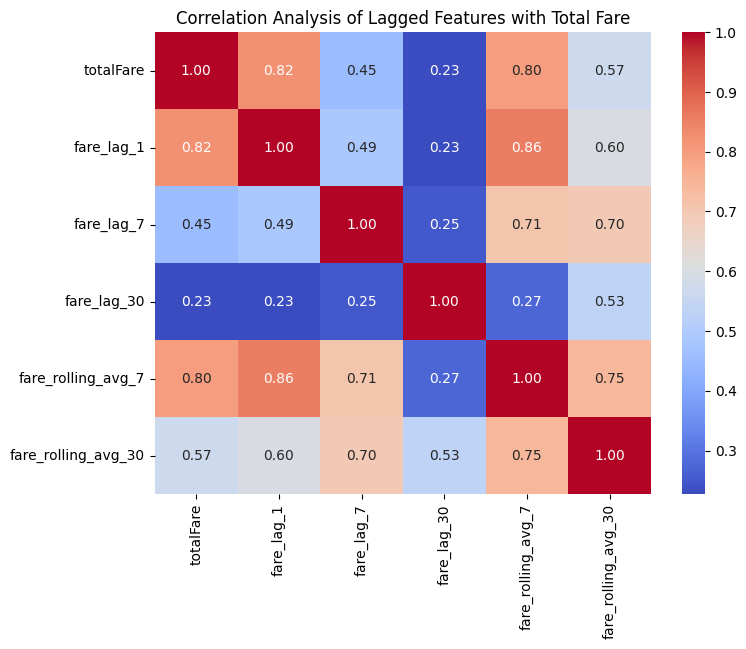

In [85]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Analysis of Lagged Features with Total Fare")
plt.show()


The most correlated features are fare_lag_1, fare_rolling_avg_7, and fare_rolling_avg_30. However, fare_lag_1 and fare_rolling_avg_7 have high correlation with each other, which may introduce redundancy into the model. One may need to be dropped if multicollinearity affects model 